<a href="https://colab.research.google.com/github/momowade221/Segmentation_Valeur_OM/blob/main/OM_Segmentation_valeur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONFIGURATION**

---



In [1]:
!pip install pyspark
# !pip install lifetimes
# !pip install kmodes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=a185527b04865eec58e2b2cd408e43a088dd83fde8bfc7bd98461922b1b0a961
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/Segmentation/
myPath='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *
from pyspark.ml import *
from pyspark.ml.clustering import *
from pyspark.sql.column import Column

# from lifetimes import BetaGeoFitter
# from lifetimes import GammaGammaFitter
# from lifetimes.plotting import plot_period_transactions

spark = SparkSession.builder.appName("Transactions_OM").getOrCreate()
# Configuration pour permettre l'analyse des dates au format Legacy
# spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
spark

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab/Segmentation


# **PRÉPARATION DES DONNÉES**

---



## **Collection des données**

In [3]:
#Selection des données sur Hive
""" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'
 ORDER BY RAND() LIMIT 100000; """

" SELECT * FROM `trusted_om`.`base_transaction_om` WHERE day >= '20230801' AND day <= '20230831'\n ORDER BY RAND() LIMIT 100000; "

In [4]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [29]:
def df_load(path, table):
    # Charger le DataFrame depuis le fichier CSV avec les colonnes existantes
    df_loaded= spark.read.csv(f'{path}', header=True)
    # BaseTransaction OM - Renommer les colonnes
    new_column_names = [col_name.replace(f"{table}.", "") for col_name in df_loaded.columns]
    df_loaded = df_loaded.toDF(*new_column_names)

    return df_loaded

#OM
df_transaction_om = df_load(f'{myPath}/base_transaction_om.csv', "base_transaction_om")

#OEM
df_transaction_oem=df_load(f'{myPath}/base_transaction_oem.csv',"base_transaction_oem")

#Transactions_OM
df_transactions=df_load(f'{myPath}/trusted_om.transactions.csv',"transactions")

#Redefined reporting
df_segment_recharge=df_load(f'{myPath}/refined_reporting.segment_recharge.csv',"segment_recharge")

#SICO
df_sico=df_load(f'{myPath}/trusted_sicli.sico.csv',"sico")

df_segment_palier=df_load(f'{myPath}/segment_palier.csv',"")

## **Exploration des données**

---



### Définition des fonctions d'exploration

In [6]:
def df_info(df: DataFrame):
   # Informations sur le schéma du DataFrame
   ############ Info ###########")
   df.printSchema()

   # Noms des colonnes
   ############ Colonnes ###########")
   print(df.columns)

   # Dimensions (nombre de lignes et de colonnes)
   ############ Dimensions ###########")
   num_rows = df.count()
   num_cols = len(df.columns)
   print(f"Nombre de lignes : {num_rows}, Nombre de colonnes : {num_cols}")

   # Afficher les premières lignes (les 5 premières lignes sans troncature)
   ############ Premières lignes ###########")
   df.show(5, truncate=False)  # Affiche les 5 premières lignes sans troncature

   # Afficher les dernières lignes (les 5 dernières lignes triées par la première colonne en ordre décroissant)
   print("\n########### Dernières lignes ###########")
   df.orderBy(df.columns[0], ascending=False).show(5, truncate=False)  # Affiche les 5 dernières lignes



def df_info_detailed(df:DataFrame):
  df_info(df)

  # Statistiques sommaires (quantiles) du DataFrame
  print("\n########### Statistiques sommaires ###########")
  df.summary().show()

  # Données manquantes (NA)
  print("\n########### Données manquantes ###########")
  # Compter le nombre de valeurs manquantes (NA) par colonne
  count_NA = df.agg(*[sum(df[c].isNull().cast("int")).alias(c) for c in df.columns])
  # Afficher le résultat
  print("Le nombre de colonnes qui contiennent des valeurs manquantes (NA)")
  count_NA.show()

  # Compter les occurrences de "NULL" dans chaque colonne
  count_exprs = [expr(f"sum(case when {c} like '%NULL%' then 1 else 0 end) as {c}_count") for c in df.columns]
  print("Le nombre de lignes qui contiennent la chaîne 'NULL'")
  count_NULL = df.select(*count_exprs)
  count_NULL.show()

  # Données dupliquées
  print("\n########### Données dupliquées ###########")

  # Find rows where all column values are identical
  duplicate_rows=df.groupBy(*df.columns).agg(count("*").alias("count"))
  duplicate_rows = duplicate_rows.filter(duplicate_rows["count"] > 1).select(*df.columns)

  if duplicate_rows.count()==0:
    print("Aucune ligne dupliquée trouvée")
  else:
    print(f"Nombre de données dupliquées : {duplicate_rows.count()}")
    # Show the rows with identical value
    duplicate_rows.show()

#Fonction pour afficher un DataFrame PySpark sous forme de Pandas DataFrame
def printdf(df):
    return df.toPandas()


In [7]:
# from pyspark.sql import functions as F
def df_colonne_info(df: DataFrame, colonne):
    # Nombre de valeurs distinctes dans la colonne
    colonne_count = df.select(colonne).distinct().count()

    # Récupérer le type de données de la colonne
    colonne_type = df.schema[colonne].dataType

    # Affichage des informations
    print(f" *****Informations sur la colonne ___{colonne}___: *****")
    # Valeurs distinctes de la colonne
    print(f"Les valeurs distinctes sont:")
    df.select(colonne).distinct().show(truncate=False)

    print(f"Nombre de valeurs distinctes : {colonne_count}")

    if isinstance(colonne_type, (FloatType,DecimalType, IntegerType)):
        # Statistiques de base sur la colonne (moyenne, écart type, minimum, maximum)
        mean = df.select(mean(colonne)).first()[0]
        stddev = df.select(stddev(colonne)).first()[0]
        min_value = df.select(min(colonne)).first()[0]
        max_value = df.select(max(colonne)).first()[0]

        # Somme des valeurs dans la colonne
        sum_value = df.select(sum(colonne)).first()[0]

        # Médiane de la colonne
        median = df.approxQuantile(colonne, [0.5], 0.01)[0]

        # 1er quartile (Q1) et 3e quartile (Q3)
        quartiles = df.approxQuantile(colonne, [0.25, 0.75], 0.01)
        q1, q3 = quartiles

        print(f"Valeur moyenne : {mean}")
        print(f"Écart type : {stddev}")
        print(f"Valeur minimale : {min_value}")
        print(f"Valeur maximale : {max_value}")
        print(f"Somme des valeurs : {sum_value}")
        print(f"Médiane : {median}")
        print(f"1er quartile (Q1) : {q1}")
        print(f"3e quartile (Q3) : {q3}")
    else:
        print("Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.")

    print("-------------------------------------------------------")


### Exploration de la table **Base_transaction_OM**

In [134]:
df_info(df_transaction_om)

root
 |-- msisdn: string (nullable = true)
 |-- destinataire: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- fees: string (nullable = true)
 |-- montant: string (nullable = true)
 |-- operation: string (nullable = true)
 |-- status: string (nullable = true)
 |-- statuscode: string (nullable = true)
 |-- titre: string (nullable = true)
 |-- transactionid: string (nullable = true)
 |-- typetransaction: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)

['msisdn', 'destinataire', 'channel', 'date', 'description', 'fees', 'montant', 'operation', 'status', 'statuscode', 'titre', 'transactionid', 'typetransaction', 'ingest_date', 'year', 'month', 'day']
Nombre de lignes : 1994000, Nombre de colonnes : 17
+-------+--------------------------------------------------------

### Exploration de la table **Base_transaction_OEM**

In [ ]:
df_info(df_transaction_oem)

root
 |-- id: string (nullable = true)
 |-- date_created: string (nullable = true)
 |-- num_ligne_beneficiary: string (nullable = true)
 |-- transaction_id: string (nullable = true)
 |-- transaction_response_code: string (nullable = true)
 |-- transaction_response_wording: string (nullable = true)
 |-- transaction_fees: string (nullable = true)
 |-- transaction_ppi: string (nullable = true)
 |-- ca_ttc: string (nullable = true)
 |-- num_ligne_owner: string (nullable = true)
 |-- transaction_source: string (nullable = true)
 |-- transaction_status: string (nullable = true)
 |-- transaction_type: string (nullable = true)
 |-- ingest_date: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)

['id', 'date_created', 'num_ligne_beneficiary', 'transaction_id', 'transaction_response_code', 'transaction_response_wording', 'transaction_fees', 'transaction_ppi', 'ca_ttc', 'num_ligne_owner', 'transaction_source', 'tra

In [ ]:
df_colonne_info(df=df_transaction_oem, colonne="transaction_ppi")

 *****Informations sur la colonne ___transaction_ppi___: *****
Les valeurs distinctes sont:
+---------------+
|transaction_ppi|
+---------------+
|          51005|
|           8442|
|           8444|
|          51011|
|         988110|
|          51003|
|          77001|
|          51002|
|          77002|
|           8490|
|          51036|
|           8446|
|          77003|
|          51050|
|              0|
|          51008|
|          51023|
|           8059|
|          99095|
|          99207|
+---------------+
only showing top 20 rows

Nombre de valeurs distinctes : 66
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


### Exploration de la table **Transaction_OM**

In [64]:
df_info(df_transactions)

root
 |-- sender_msisdn: string (nullable = true)
 |-- receiver_msisdn: string (nullable = true)
 |-- receiver_user_id: string (nullable = true)
 |-- sender_user_id: string (nullable = true)
 |-- transaction_amount: string (nullable = true)
 |-- commissions_paid: string (nullable = true)
 |-- commissions_received: string (nullable = true)
 |-- commissions_others: string (nullable = true)
 |-- service_charge_received: string (nullable = true)
 |-- service_charge_paid: string (nullable = true)
 |-- taxes: string (nullable = true)
 |-- service_type: string (nullable = true)
 |-- transfer_status: string (nullable = true)
 |-- sender_pre_bal: string (nullable = true)
 |-- sender_post_bal: string (nullable = true)
 |-- receiver_pre_bal: string (nullable = true)
 |-- receiver_post_bal: string (nullable = true)
 |-- sender_acc_status: string (nullable = true)
 |-- receiver_acc_status: string (nullable = true)
 |-- error_code: string (nullable = true)
 |-- error_desc: string (nullable = true)
 

### Exploration de la table **Segment_recharge**

In [30]:
df_info(df_segment_recharge)
# df_info_detailed(df_segment_recharge)

root
 |-- msisdn: string (nullable = true)
 |-- avg_montant_recharge: string (nullable = true)
 |-- segment_recharge: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)

['msisdn', 'avg_montant_recharge', 'segment_recharge', 'year', 'month']
Nombre de lignes : 248773, Nombre de colonnes : 5
+-------+--------------------+----------------+----+-----+
|msisdn |avg_montant_recharge|segment_recharge|year|month|
+-------+--------------------+----------------+----+-----+
|2331055|20866.666666666668  |Haut de marché  |2023|07   |
|1243   |29143.0             |Haut de marché  |2023|07   |
|2330127|20224.0             |Haut de marché  |2023|07   |
|2620   |21633.333333333332  |Haut de marché  |2023|07   |
|1425881|28833.333333333332  |Haut de marché  |2023|07   |
+-------+--------------------+----------------+----+-----+
only showing top 5 rows


########### Dernières lignes ###########
+------+--------------------+-------------------+----+-----+
|m

In [28]:
df_colonne_info(df_segment_recharge,"segment_recharge")

 *****Informations sur la colonne ___segment_recharge___: *****
Les valeurs distinctes sont:
+-------------------+
|segment_recharge   |
+-------------------+
|Milieu de marché   |
|Très Haut de marché|
|Mass-Market        |
|Haut de marché     |
+-------------------+

Nombre de valeurs distinctes : 4
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


In [91]:
# Trouvez l'année maximale
max_year = df_segment_recharge.agg({"year": "max"}).collect()[0][0]

# Filtrer le DataFrame pour obtenir les lignes avec l'année maximale
max_month = df_segment_recharge.filter(col("year") == max_year)\
            .agg({"month": "max"}).collect()[0][0]

df_latest_segment_recharge = df_segment_recharge.filter((col("year") == max_year) & (col("month") == max_month))
df_latest_segment_recharge.show()

+-------+--------------------+----------------+----+-----+
| msisdn|avg_montant_recharge|segment_recharge|year|month|
+-------+--------------------+----------------+----+-----+
|1000013|   8966.666666666666|Milieu de marché|2023|   08|
|1000016|              2000.0|     Mass-Market|2023|   08|
|1000143|   6026.666666666667|     Mass-Market|2023|   08|
|1000166|   733.3333333333334|     Mass-Market|2023|   08|
|1000203|  3029.3333333333335|     Mass-Market|2023|   08|
|1000223|              6050.0|     Mass-Market|2023|   08|
| 100026|              3202.0|     Mass-Market|2023|   08|
|1000269|  1075.3333333333333|     Mass-Market|2023|   08|
|1000308|               750.0|     Mass-Market|2023|   08|
|1000345|             12530.0|  Haut de marché|2023|   08|
|1000401|  1145.3333333333333|     Mass-Market|2023|   08|
|1000429|  166.66666666666666|     Mass-Market|2023|   08|
|1000496|               700.0|     Mass-Market|2023|   08|
|1000504|              2400.0|     Mass-Market|2023|   0

In [80]:
max_year=df_segment_recharge.select("year","month").groupBy("year").agg(max("year"))
max_year.show()
# df_segment_recharge.select("year","month").where(col("year")==2023& month).distinct().show()

+----+---------+
|year|max(year)|
+----+---------+
|2022|     2022|
|2023|     2023|
+----+---------+



### Exploration de la table **Sico**

In [31]:
df_info(df_sico)

root
 |-- civilite: string (nullable = true)
 |-- nom: string (nullable = true)
 |-- prenom: string (nullable = true)
 |-- nd: string (nullable = true)
 |-- imsi: string (nullable = true)
 |-- type_contrat: string (nullable = true)
 |-- id_client: string (nullable = true)
 |-- id: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- date_naissance: string (nullable = true)
 |-- date_debut_engagement: string (nullable = true)
 |-- statut: string (nullable = true)
 |-- forfait_voix: string (nullable = true)
 |-- forfait_data: string (nullable = true)
 |-- forfait_fbi: string (nullable = true)
 |-- cug: string (nullable = true)
 |-- type_piece: string (nullable = true)
 |-- numero_piece: string (nullable = true)
 |-- adresse: string (nullable = true)
 |-- filename: string (nullable = true)
 |-- filename_nessico: string (nullable = true)
 |-- login_agent: string (nullable = true)
 |-- prenom_agent: string (nullable = true)
 |-- nom_agent: string (nullable = true)
 |-- msisd

In [111]:
df_colonne_info(df_sico, 'civilite')

 *****Informations sur la colonne ___civilite___: *****
Les valeurs distinctes sont:
+--------------+
|civilite      |
+--------------+
|Mademoiselle  |
|Madame        |
|Soci�t�       |
|Monsieur      |
|Etablissements|
|Service       |
|NULL          |
+--------------+

Nombre de valeurs distinctes : 7
Les calculs statistiques ne sont pas applicables car le type de données n'est pas numérique.
-------------------------------------------------------


In [110]:
df_sico.select("type_contrat", "segment").distinct().orderBy("type_contrat").show(truncate=False)

+----------------------------------------------------------------------+---------+
|type_contrat                                                          |segment  |
+----------------------------------------------------------------------+---------+
|POSTPAID-OCS_BEW-OTS_BEW                                              |GCO      |
|POSTPAID-OCS_RPE_TERANGA_ACCESS-OTS_TERANGA_ACCESS                    |GCO      |
|POSTPAID-OCS_RPE_TERANGA_INITIAL-OTS_RPE_TERANGA_INITIAL              |ENT      |
|POSTPAID-OCS_RPE_TERANGA_PREMIUM_BLOQUE-OTS_RPE_TERANGA_PREMIUM_BLOQUE|GCO      |
|POSTPAID-OCS_RPE_TERANGA_PREMIUM_BLOQUE-OTS_RPE_TERANGA_PREMIUM_BLOQUE|SOHO     |
|POSTPAID-OCS_TERANGA_PREMIUM_BLOQUE-OTS_TERANGA_PREMIUM_BLOQUE        |PA1      |
|PREPAID-Jamono Allo                                                   |PLATINIUM|
|PREPAID-Jamono Allo                                                   |NEANT    |
|PREPAID-Jamono Allo                                                   |GOLD     |
|PRE

In [126]:
df_sico.withColumn("entite",
          when((col("civilite") == "Mademoiselle") | (col("civilite") == "Madame") | (col("civilite") == "Monsieur"), "Personne physique")
          .when((col("civilite") == "Soci�t�") | (col("civilite") == "Etablissements") | (col("civilite") == "Service"), "Personne morale")
          .otherwise("Autre")) \
          .drop("civilite") \
          .show()

+--------------------+---------+-------+--------------------+--------------------+----------+--------+-------+--------------+---------------------+------+------------+------------+-----------+----+--------------------+--------------------+--------------------+--------------------+----------------+--------------------+--------------+--------------+--------------------+--------------------+--------------------+--------------------+----+-----+--------+-----------------+
|                 nom|   prenom|     nd|                imsi|        type_contrat| id_client|      id|segment|date_naissance|date_debut_engagement|statut|forfait_voix|forfait_data|forfait_fbi| cug|          type_piece|        numero_piece|             adresse|            filename|filename_nessico|         login_agent|  prenom_agent|     nom_agent|        msisdn_agent|       accueil_agent|     direction_agent|         ingest_date|year|month|     day|           entite|
+--------------------+---------+-------+----------------

### Exploration de la table **Segment Palier**

In [ ]:
df_info(df_segment_palier)

root
 |-- msisdn: string (nullable = true)
 |-- chiffre_affaires: string (nullable = true)
 |-- segment: string (nullable = true)
 |-- limites_segment: string (nullable = true)
 |-- limites_segment_str: string (nullable = true)

['msisdn', 'chiffre_affaires', 'segment', 'limites_segment', 'limites_segment_str']
Nombre de lignes : 121360, Nombre de colonnes : 5
+-------+----------------+------------+------------------------+-------------------+
|msisdn |chiffre_affaires|segment     |limites_segment         |limites_segment_str|
+-------+----------------+------------+------------------------+-------------------+
|860974 |6550.0          |1e quantile |[0.0, 10000.0]          |0.0-10000.0        |
|68090  |990000.0        |10e quantile|[801500.0, 1000000000.0]|801500.0-1.0E9     |
|1191737|44000.0         |4e quantile |[30000.0, 50000.0]      |30000.0-50000.0    |
|2484229|530000.0        |9e quantile |[337000.0, 801500.0]    |337000.0-801500.0  |
|1247131|6500.0          |1e quantile |[0.

## **Prétraitement des données**

### Transformation des données

In [8]:
def df_transform(df: DataFrame):
    # Transformation en minuscule de la colonne Type transaction
    df = df.withColumn("typetransaction", lower(df["typetransaction"]))

    # Sélection des Colonnes Nécessaires
    no_taken_columns = ["fees", "transactionid", "operation", "destinataire", "date", "month", "year", "ingest_date", "description", "status", "statuscode"]
    taken_columns = ["msisdn", "montant", "day", "typetransaction", "titre", "channel"]
    df = df.select(taken_columns)

    # Sélection des colonnes nécessaires et renommage
    df = df.select(taken_columns) \
        .withColumnRenamed("msisdn", "Numero") \
        .withColumnRenamed("day", "Date") \
        .withColumnRenamed("typetransaction", "Type_transaction") \
        .withColumnRenamed("montant", "Montant") \
        .withColumnRenamed("titre", "Titre_transaction") \
        .withColumnRenamed("channel", "Channel")

    # Supprimer les lignes où 'Montant' est égal à "NULL"
    df = df.filter(df["Montant"] != "NULL")

    # Conversion des données des colonnes Date et Montant
    df = df.withColumn("Montant", df["Montant"].cast(FloatType()))
    df_transformed = df.withColumn("Date", to_date(df["Date"], "yyyyMMdd"))

    return df_transformed

### Nettoyage des données

In [9]:
def df_clean(df):
    # Données manquantes sur la colonne TypesTransaction
    df = df.withColumn("Titre_transaction",
                      when((df["Type_transaction"] == "cashin") & (df["Titre_transaction"] == "NULL"), "Depot")
                      .when((df["Type_transaction"] == "cashin") & (df["Titre_transaction"] == "Dépot"), "Depot")
                      .when((df["Type_transaction"] == "achat_credit") & (df["Titre_transaction"] == "Recharge Crédit"), "Recharge Credit")
                      .when((df["Type_transaction"] == "cashout") & (df["Titre_transaction"] == "NULL"), "Retrait")
                      .when((df["Type_transaction"] == "transfert") & (df["Titre_transaction"] == "NULL"), "Transfert")
                      .when((df["Type_transaction"] == "cashinother") & (df["Titre_transaction"] == "NULL"), "Autre retrait")
                      .when((df["Type_transaction"] == "cashout_confirm") | (df["Type_transaction"] == "cashout") & (df["Titre_transaction"] == "Retrait d'argent"), "Retrait")
                      .when((df["Type_transaction"] == "paiement_marchand") & (df["Titre_transaction"] == "NULL"), "Paiement marchand")
                      .otherwise(df["Titre_transaction"])
                      )

    # Données manquantes sur la colonne Channel
    df = df.withColumn("Channel", when(df["Channel"] == "NULL", "Inconnu").otherwise(df["Channel"]))

    # Gestion des données aberrantes
    df = df.filter(df["Montant"] > 0)

    # Gestion des données dupliquées
    df_cleaned = df.dropDuplicates()
    return df_cleaned


###Sauvegarde des données

In [10]:
#Définition des dataframes préparés
df_transformed=df_transform(df_transaction_om)
df_prepared=df_clean(df_transformed)

In [ ]:
# Affichage des résultats
df_prepared.printSchema()
df_prepared.show()

root
 |-- Numero: string (nullable = true)
 |-- Montant: float (nullable = true)
 |-- Date: date (nullable = true)
 |-- TypeTransaction: string (nullable = true)
 |-- TitreTransaction: string (nullable = true)
 |-- Channel: string (nullable = true)

+-------+--------+----------+-------------------+----------------+-------------+
| Numero| Montant|      Date|    TypeTransaction|TitreTransaction|      Channel|
+-------+--------+----------+-------------------+----------------+-------------+
| 914236| 10000.0|2022-03-21|            cashout|         Retrait|         USSD|
|1150536|  3500.0|2022-03-05|            cashout|         Retrait|         USSD|
|2079639|11336.24|2022-03-23|   paiement_facture|             SDE|       mobile|
| 176177| 26000.0|2022-03-08|             cashin|           Depot|         USSD|
| 843595| 5695.39|2022-03-21|   paiement_facture|             SDE|       mobile|
| 510908| 10500.0|2022-03-29|             cashin|           Depot|         USSD|
|1874594|  1000.0|202

In [21]:
def df_save(df: DataFrame, pathForSave) :
  df_saved=df.toPandas().to_csv(pathForSave, index=False)
  return df_saved

df_saved=df_save(df_prepared, '#datasets_OM/base_transaction_om_prepared.csv')

In [ ]:
pd_transaction_om=pd.read_csv('#datasets_OM/base_transaction_om_prepared.csv')
pd_transaction_om.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1861616 entries, 0 to 1861615
Data columns (total 6 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Numero            int64  
 1   Montant           float64
 2   Date              object 
 3   TypeTransaction   object 
 4   TitreTransaction  object 
 5   Channel           object 
dtypes: float64(1), int64(1), object(4)
memory usage: 85.2+ MB


### Visualisations

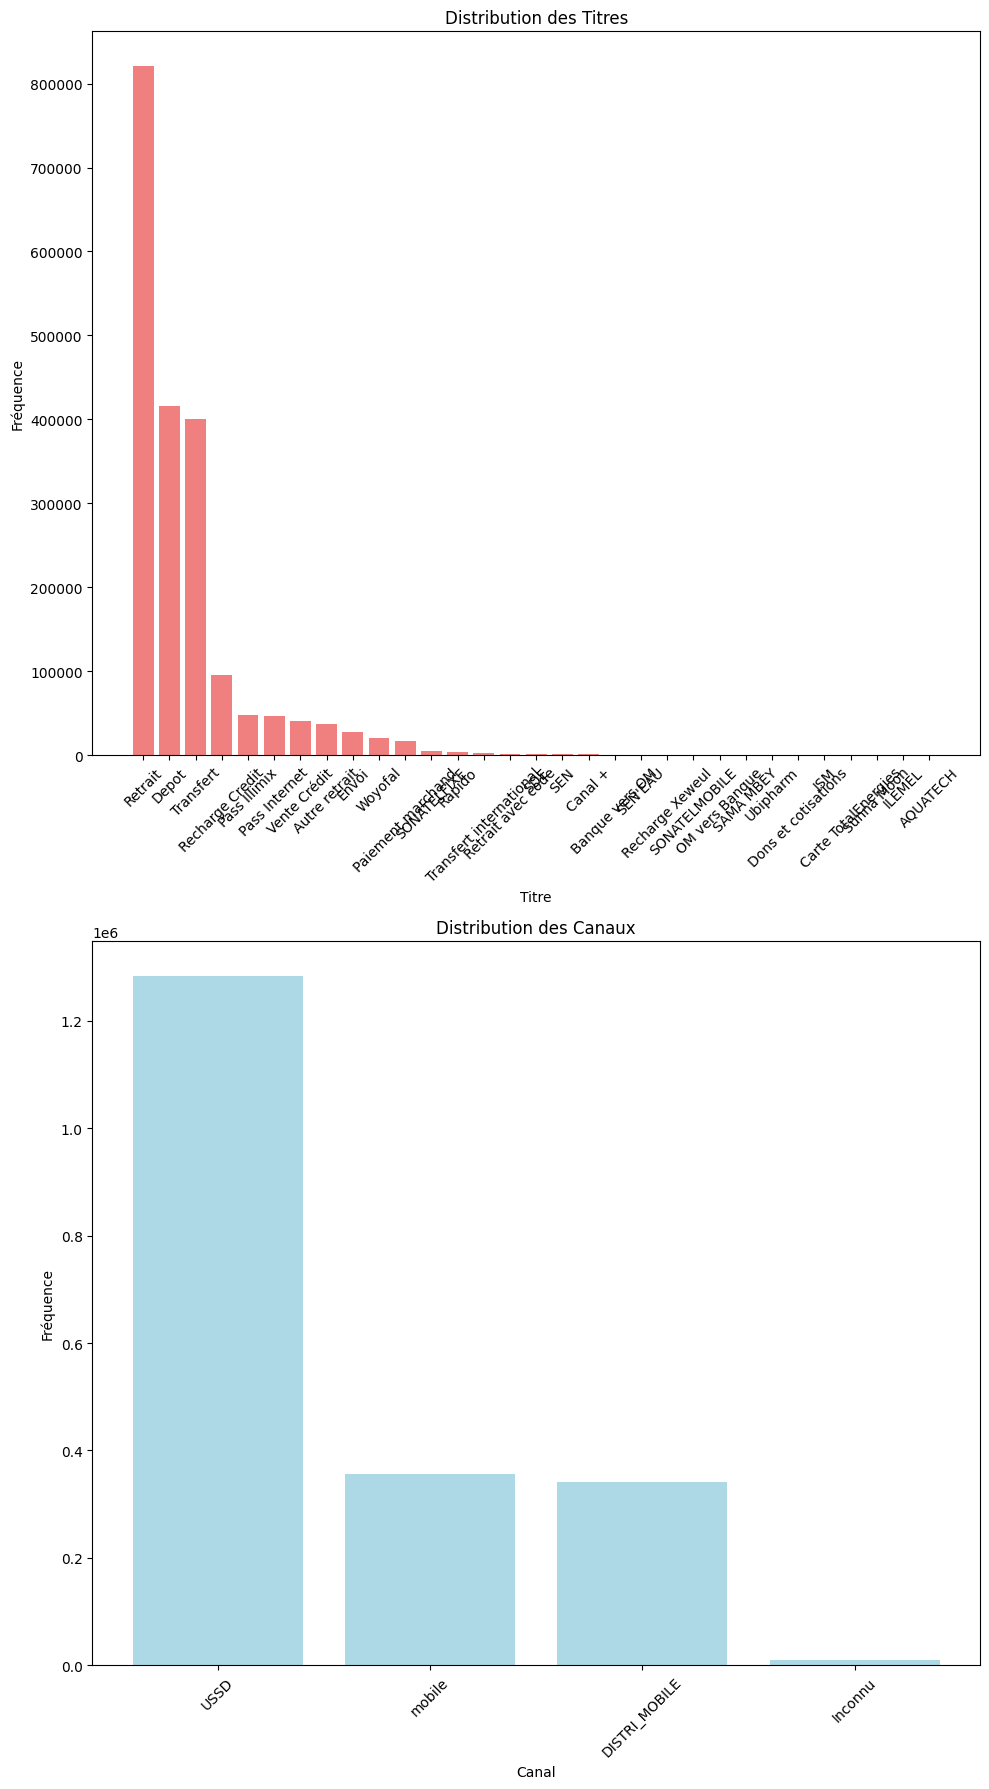

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez un DataFrame Pandas 'pd_transaction_om' avec les données
pd_transaction_om=pd_transaction_om
# Créez une figure avec des sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(10, 18))


# Sous-graphique 1 : Distribution des Titres
titre_counts = pd_transaction_om['TitreY'].value_counts()
axes[0].bar(titre_counts.index, titre_counts.values, color='lightcoral')
axes[0].set_title('Distribution des Titres')
axes[0].set_xlabel('Titre')
axes[0].set_ylabel('Fréquence')
axes[0].tick_params(axis='x', rotation=45)

# Sous-graphique 2 : Distribution des Canaux
channel_counts = pd_transaction_om['Channel'].value_counts()
axes[1].bar(channel_counts.index, channel_counts.values, color='lightblue')
axes[1].set_title('Distribution des Canaux')
axes[1].set_xlabel('Canal')
axes[1].set_ylabel('Fréquence')
axes[1].tick_params(axis='x', rotation=45)


# # Sous-graphique 1 : Distribution des Montants (Intervalles de 10,000)
# montants = pd_transaction_om['Montant'].astype(float)
# bins = range(0, int(montants.max()) + 10000, 10000)
# hist, edges = np.histogram(montants, bins=bins)
# axes[2].hist(montants, bins=bins, color='skyblue', edgecolor='black')
# axes[2].set_xticks(edges)
# axes[2].set_xticklabels([f'{edges[i]:,.0f}-{edges[i+1]:,.0f}' for i in range(len(edges) - 1)])
# axes[2].set_title('Distribution des Montants (Intervalles de 10,000)')
# axes[2].set_xlabel('Montant')
# axes[2].set_ylabel('Fréquence')


# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichez les sous-graphiques
plt.show()


# **MODÉLISATION POUR LA SEGMENTATION MULTISERVICE**

---



In [15]:
def segmenter_multiservice(df: DataFrame):
    # Groupement par client (Numéro) et collecte des types de transactions uniques et des canaux uniques
    channel_set = collect_set(df["Channel"]).alias("Canaux")
    service_set=collect_set(df["Titre_transaction"]).alias("Services")
    multiservice_segmentation = df.groupBy("Numero").agg(
        service_set,
        size(service_set).alias("Nombre_services"),
        channel_set,
        size(channel_set).alias("Nombre_canaux"),
    )

    # Définir la valeur du seuil
    seuil = 1
    # Calcul du segment
    multiservice_segmentation = multiservice_segmentation.withColumn("Segment_service", when(multiservice_segmentation["Nombre_services"] <= seuil, "Monoservice").otherwise("Multiservice"))

    return multiservice_segmentation


# Appeler la fonction pour calculer la segmentation des clientsd
df_segment_multiservice = segmenter_multiservice(df_prepared)
# # Afficher le résultat
df_segment_multiservice.printSchema()

root
 |-- Numero: string (nullable = true)
 |-- Services: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_services: integer (nullable = false)
 |-- Canaux: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- Nombre_canaux: integer (nullable = false)
 |-- Segment_service: string (nullable = false)



In [16]:
def profil_client_multiservice(numero):
    # Calcul de la segmentation multiservice pour l'ensemble des clients
    # profil_client_multiservice = segmenter_multiservice(df_prepared)
    profil_client = df_segment_multiservice
    # Filtrage du profil du client en fonction du numéro donné
    profil_client = profil_client.filter(profil_client["Numero"] == numero).collect()
    # Conversion du profil du client en dictionnaire et collecte du résultat
    profil_client = [row.asDict() for row in profil_client]

    # Retourne le premier (et unique) élément du résultat, qui est un dictionnaire
    return profil_client


In [27]:
# Appel de la fonction pour obtenir le profil du client
profil_client_multiservice(numero=1000339)

[{'Numero': '1000339',
  'Services': ['Retrait', 'Transfert'],
  'Nombre_services': 2,
  'Canaux': ['USSD'],
  'Nombre_canaux': 1,
  'Segment_service': 'Multiservice'}]

# **MODÉLISATION POUR LA SEGMENTATION SELON LA VALEUR**

---



## **Méthode K-Means**

---





### Feature engineering

In [38]:
latest_date = to_date(lit("2023/08/17"), 'yyyy/MM/dd')
def df_kmeans_create(df_transaction: DataFrame,df_sico:DataFrame, df_segment_palier: DataFrame, df_segment_recharge :DataFrame,df_segment_multiservice:DataFrame) -> DataFrame:

    # Integration des donnés SICO
    taken_columns_sico = [ 'nd', 'date_naissance', 'date_debut_engagement' ,'statut']
    df_sic = df_sico.select(taken_columns_sico)  \
                    .withColumnRenamed("nd", "Numero")
    df_sic= df_sic.withColumn("Age", year(current_date()) - year("date_naissance")).drop("date_naissance")\
                  .withColumn("Anciennete",  year(current_date()) - year("date_debut_engagement")).drop("date_debut_engagement")


    #Aggrégation des données de la Base_transaction préparées
    df_transaction_aggregated=df_transaction.groupBy("Numero").agg(
       datediff(latest_date,max(df_transaction["Date"])).alias("Recence"),
       count("*").alias("Frequence"),
       sum(df_transaction["Montant"].cast("double")).alias("Chiffre_affaire")
       )

  #Integration des donnés de la segmentation palier
    taken_columns_palier=['msisdn','limites_segment']
    df_palier = df_segment_palier.select(taken_columns_palier) \
            .withColumnRenamed("msisdn", "Numero")  \
            .withColumnRenamed('limites_segment','palier')


    #Integration des donnés de la segmentation multiservice
    df_multiservice=df_segment_multiservice.drop("Segment_service")

    #Intégration des données de la segmentation recharge
    max_year_df_recharge = df_segment_recharge.agg({"year": "max"}).collect()[0][0]
    max_month_df_recharge = df_segment_recharge.filter(col("year") == max_year_df_recharge)\
            .agg({"month": "max"}).collect()[0][0]
    df_latest_segment_recharge = df_segment_recharge.withColumnRenamed("msisdn","Numero")\
                                  .withColumnRenamed("segment_recharge","latest_segment_recharge") \
                                  .filter((col("year") == max_year_df_recharge) & (col("month") == max_month_df_recharge)) \
                                  .select("Numero","latest_segment_recharge")

    #Jointure des Dataframes
    df_joined= df_sic.join(df_transaction_aggregated, "Numero", "inner")\
    .join(df_palier,"Numero", "inner") \
    .join(df_multiservice,"Numero", "inner")\
    # .join(df_latest_segment_recharge,"Numero", "inner")
    df_joined=df_joined.drop("Services","Canaux")

    uppercase_columns = [col(column_name).alias(column_name.capitalize()) for column_name in df_joined.columns]

    # Select the DataFrame with uppercase column names
    df_km_created= df_joined.select(*uppercase_columns)
    return df_km_created


In [36]:
def df_kmeans_encode(df_to_encode:DataFrame, categorical_columns: list):
    #Encodage des variables catégorielles
    # Initialiser les étapes pour le pipeline
    df_to_encode=df_to_encode
    etapes = []

    # Appliquer StringIndexer pour l'encodage des étiquettes
    for col in categorical_columns:
        indexer = StringIndexer(inputCol=col, outputCol=col + "Index")
        etapes.append(indexer)

    # Créer un pipeline
    pipeline = Pipeline(stages=etapes)

    # Ajuster et transformer le DataFrame à l'aide du pipeline
    model = pipeline.fit(df_to_encode)
    df_encoded = model.transform(df_to_encode)
    return df_encoded


In [39]:
df_kmeans_created=df_kmeans_create(df_transaction=df_prepared,df_sico=df_sico, df_segment_recharge=df_segment_recharge,df_segment_palier=df_segment_palier, df_segment_multiservice=df_segment_multiservice)

AnalysisException: ignored

In [27]:
df_kmeans_created.show()

+-------+------+----+----------+-------+---------+---------------+--------------------+---------------+-------------+
| Numero|Statut| Age|Anciennete|Recence|Frequence|Chiffre_affaire|              Palier|Nombre_services|Nombre_canaux|
+-------+------+----+----------+-------+---------+---------------+--------------------+---------------+-------------+
|1001458| ACTIF|  38|        15|    171|        2|         4000.0|      [0.0, 10000.0]|              1|            1|
|1002729| ACTIF|  59|        10|      2|       29|      2420300.0|[337000.0, 801500.0]|              5|            3|
|1003356| ACTIF|  31|        10|      0|       16|        87800.0|      [0.0, 10000.0]|              5|            2|
|1005565| ACTIF|  51|        10|      2|       11|        12200.0|      [0.0, 10000.0]|              3|            1|
|1006709| ACTIF|  37|        10|    132|       11|       127400.0|      [0.0, 10000.0]|              3|            2|
| 100915| ACTIF|  31|         7|    144|        4|      

In [ ]:
df_kmeans_encoded=df_kmeans_encode(df_kmeans_created, categorical_columns=["Segment_service","Statut","Latest_segment_recharge","Palier"])

### Nombre de clusters

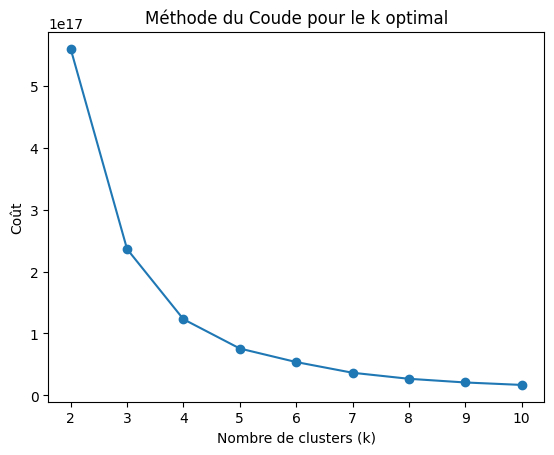

In [ ]:
def elbow_method(df, feature_columns):
    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Essayer différentes valeurs de k et évaluer leur coût
    cost = []
    for k in range(2, 11):
        kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
        model = kmeans.fit(df_kmeans)
        cost.append(model.summary.trainingCost)

    # Tracé du coût en fonction du nombre de clusters (méthode du coude)
    plt.plot(range(2, 11), cost, marker='o')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Coût')
    plt.title('Méthode du Coude pour le k optimal')
    plt.show()

# Exemple d'utilisation
feature_columns = ["Recence", "Frequence", "Montant_total", "Nombre_services", "Segment_serviceIndex"]
elbow_method(df_kmeans_created, feature_columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

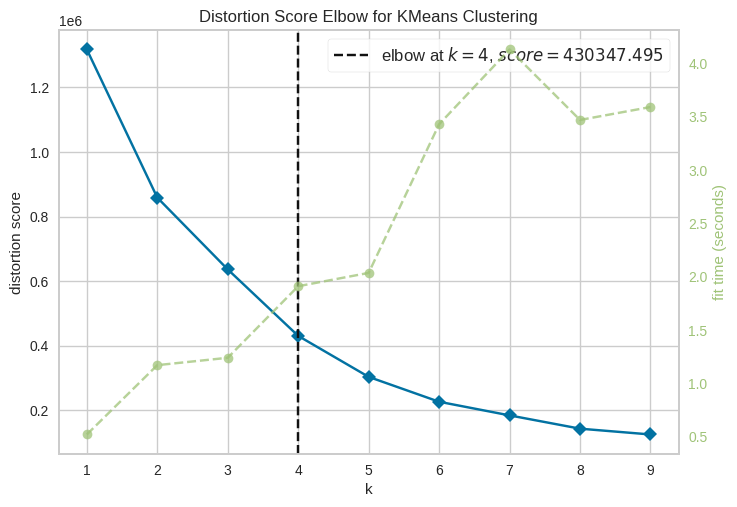

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from pyspark.sql import DataFrame

def visualize_elbow(df: DataFrame):
    # Sélectionner les colonnes RFM pour l'analyse
    pd_kmeans = df.toPandas()
    kmeans_features = pd_kmeans[["Recence", "Frequence", "Montant_total", "Nombre_services", "Segment_serviceIndex"]]

    # Standardisation des caractéristiques
    scaler = StandardScaler()
    kmeans_features_scaled = scaler.fit_transform(kmeans_features)

    # Créer une instance du KElbowVisualizer
    visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1, 10))

    # Ajuster le modèle et le visualizer
    visualizer.fit(kmeans_features_scaled)

    # Afficher le graphique
    visualizer.show()

# Exemple d'utilisation
visualize_elbow(df_kmeans_created)

### Modèle

In [ ]:
def df_kmeans_model_train(df: DataFrame, optimal_k: int):
    feature_columns = ["Recence", "Frequence", "Montant_total", "Nombre_services", "Segment_serviceIndex"]
    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Initialize the K-Means model
    kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")

    # Fit the K-Means model to the data
    model = kmeans.fit(df_kmeans)

    # Save the K-Means model to the specified path
    # model.write().overwrite().save(model_path)
    # return model

    # Effectue la transformation des données
    clustered_df = model.transform(df_kmeans)

    # Renomme la colonne "prediction" en "Cluster" et supprime la colonne "features"
    df_val_kmeans = clustered_df.withColumnRenamed("prediction", "Cluster").drop("features")

    return df_val_kmeans


In [ ]:
# df_kmeans_created = df_kmeans_create(df_om_prepared, ["Segment_service"])
df_segment_valeur_kmeans = df_kmeans_model_train(df=df_kmeans_created, optimal_k=4)

In [ ]:
df_segment_valeur_kmeans.show(2)

+-------+-------+---------+------------+--------------+------------+---------------+--------------------+-------+
| Numero|Recence|Frequence|MontantTotal|NombreServices|NombreCanaux|Segment_service|Segment_serviceIndex|Cluster|
+-------+-------+---------+------------+--------------+------------+---------------+--------------------+-------+
|1000000|    167|        5|     68500.0|             3|           1|   Multiservice|                 1.0|      0|
|1000001|     92|        5|     18150.0|             3|           2|   Multiservice|                 1.0|      0|
+-------+-------+---------+------------+--------------+------------+---------------+--------------------+-------+
only showing top 2 rows



In [ ]:
segment_valeur_kmeans = df_segment_valeur_kmeans.collect()
[row.asDict() for row in segment_valeur_kmeans]
segment_valeur_kmeans

[Row(Numero='1000000', Recence=167, Frequence=5, MontantTotal=68500.0, NombreServices=3, NombreCanaux=1, Segment_service='Multiservice', Segment_serviceIndex=1.0, Cluster=0),
 Row(Numero='1000001', Recence=92, Frequence=5, MontantTotal=18150.0, NombreServices=3, NombreCanaux=2, Segment_service='Multiservice', Segment_serviceIndex=1.0, Cluster=0),
 Row(Numero='1000038', Recence=123, Frequence=2, MontantTotal=6500.0, NombreServices=2, NombreCanaux=2, Segment_service='Multiservice', Segment_serviceIndex=1.0, Cluster=0),
 Row(Numero='1000048', Recence=3, Frequence=4, MontantTotal=105000.0, NombreServices=3, NombreCanaux=1, Segment_service='Multiservice', Segment_serviceIndex=1.0, Cluster=0),
 Row(Numero='1000054', Recence=448, Frequence=1, MontantTotal=7000.0, NombreServices=1, NombreCanaux=1, Segment_service='Monoservice', Segment_serviceIndex=0.0, Cluster=0),
 Row(Numero='100008', Recence=179, Frequence=8, MontantTotal=136100.0, NombreServices=3, NombreCanaux=2, Segment_service='Multiser

In [ ]:
from pyspark.ml.clustering import KMeans
def df_kmeans_modelTrainSave(df, feature_columns: list,  optimal_k: int, model_path: str):

    # Assemble the features into a single vector column
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Initialize the K-Means model
    kmeans = KMeans().setK(optimal_k).setSeed(1).setFeaturesCol("features")

    # Fit the K-Means model to the data
    model = kmeans.fit(df_kmeans)

    # Save the K-Means model to the specified path
    model.write().overwrite().save(model_path)

    return model


In [ ]:
def df_kmeans_cluster(df, feature_columns, model_path):

    # Assemble les caractéristiques en une seule colonne de vecteurs
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df_kmeans = assembler.transform(df)

    # Charge le modèle K-Means sauvegardé
    model = KMeansModel.load(model_path)

    # Effectue la transformation des données
    clustered_df = model.transform(df_kmeans)

    # Renomme la colonne "prediction" en "Cluster" et supprime la colonne "features"
    clustered_df = clustered_df.withColumnRenamed("prediction", "Cluster").drop("features")

    return clustered_df


In [ ]:
feature_columns = ["Recence", "Frequence", "Montant_total", "Nombre_services", "Segment_serviceIndex"]
model_path = "#models_OM/model_OM_Kmeans"  # Chemin de sauvegarde du modèle
optimal_k = 4  # Nombre optimal de clusters
df_kmeans_modelTrainSave(df_kmeans_created, feature_columns, optimal_k, model_path)

KMeansModel: uid=KMeans_9301d44e5007, k=4, distanceMeasure=euclidean, numFeatures=5

In [ ]:
df_kmeans = df_kmeans_cluster(df_kmeans_created, feature_columns, model_path)
df_info(df_kmeans)

root
 |-- Numero: string (nullable = true)
 |-- Recence: integer (nullable = true)
 |-- Frequence: long (nullable = false)
 |-- MontantTotal: double (nullable = true)
 |-- NombreServices: integer (nullable = false)
 |-- NombreCanaux: integer (nullable = false)
 |-- Segment_service: string (nullable = false)
 |-- Segment_serviceIndex: double (nullable = false)
 |-- Cluster: integer (nullable = false)

['Numero', 'Recence', 'Frequence', 'MontantTotal', 'NombreServices', 'NombreCanaux', 'Segment_service', 'Segment_serviceIndex', 'Cluster']
Nombre de lignes : 263538, Nombre de colonnes : 9
+-------+-------+---------+------------+--------------+------------+---------------+--------------------+-------+
|Numero |Recence|Frequence|MontantTotal|NombreServices|NombreCanaux|Segment_service|Segment_serviceIndex|Cluster|
+-------+-------+---------+------------+--------------+------------+---------------+--------------------+-------+
|1000000|167    |5        |68500.0     |3             |1         

### Visualisation des segments K-Means

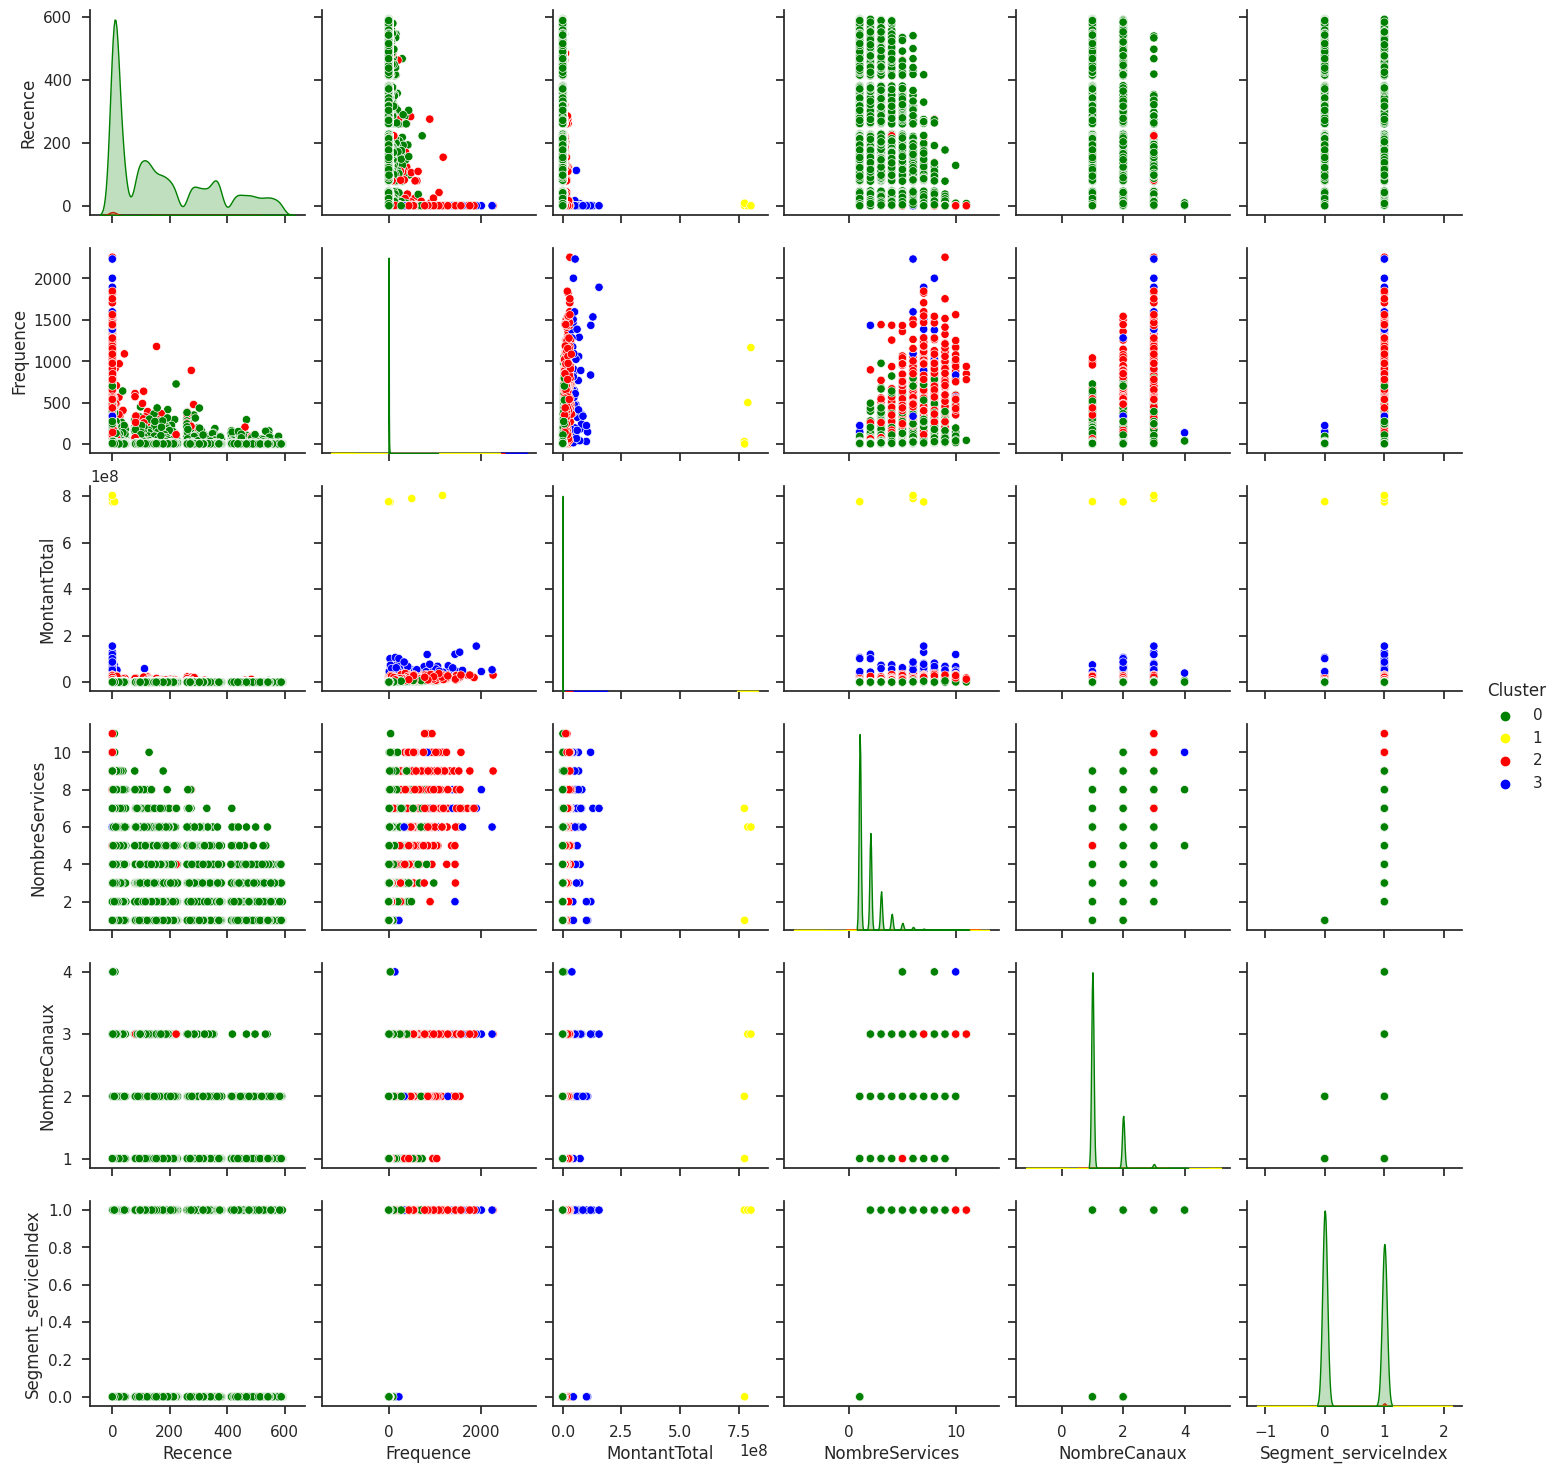

In [ ]:
# Convertir le DataFrame Spark en DataFrame Pandas
pd_kmeans =df_kmeans.toPandas()

# Définir la palette de couleurs
cluster_colors = ["green", "yellow", "red", "blue"]  # Vous pouvez personnaliser ces couleurs

# Créer le pairplot en utilisant la palette de couleurs
sns.set(style="ticks")
sns.pairplot(pd_kmeans, hue="Cluster",  palette=cluster_colors)

# Afficher le pairplot
plt.show()


### Profilage des segments

In [ ]:
# df_kmeans =  (df_kmeans
#     .withColumn('Segment',
#         when(col('Cluster')==0, lit('Very High'))
#         .when(col('Cluster')==1, lit('High'))
#         .when(col('Cluster')==2, lit('Medium'))
#          .when(col('Cluster')==3, lit('Low'))
#         .otherwise(lit('Autre'))
#     )
# )

# df_kmeans.filter(col("Segment_service")=="Medium").show()

## **Méthode RFM**

### Feature engineering

In [ ]:
def df_rfm_prepare(df):
    # Sélection des colonnes pertinentes pour RFM : Numero, Montant, Date
    df_rfm = df.select("Numero", "Montant", "Date")

    # Calcul de la date maximale dans le DataFrame
    max_date = df_rfm.agg(max("Date").alias("max_date")).collect()[0]["max_date"]

    # Convert the max_date string to a date object
    latest_date = datetime.strptime(max_date, '%Y-%m-%d')

    # Calcul de la récence (Recency)
    df_recency = df_rfm.groupBy("Numero").agg(
        datediff(lit(latest_date), max(df["Date"])).alias("Recence")
    )

    # Calcul de la fréquence (Frequency, le nombre de transactions)
    df_frequency = df_rfm.groupBy("Numero").agg(
        count("*").alias("Frequence")
    )

    # Calcul de la valeur monétaire (Monetary Value, montant total des transactions)
    df_monetary = df_rfm.groupBy("Numero").agg(
        sum("Montant").alias("Montant")
    )

    # Jointure des DataFrames Recency, Frequency et Monetary
    df_rfm = df_recency.join(df_frequency, "Numero", "inner").join(df_monetary, "Numero", "inner")

    return df_rfm

### Calcul des scores

In [ ]:
def calculer_scores_rfm(df_rfm):
    # Calculer les quantiles pour les caractéristiques Recence, Frequence et Montant
    quantiles = df_rfm.approxQuantile(["Recence", "Frequence", "Montant"], [0.2, 0.4, 0.6, 0.8], 0.01)

    # Définir des expressions conditionnelles pour attribuer les scores R, F, et M
    df_rfm = (df_rfm
        .withColumn("R_Score",  when(df_rfm["Recence"] <= quantiles[0][0], lit(5))
                                .when(df_rfm["Recence"] <= quantiles[0][1], lit(4))
                                .when(df_rfm["Recence"] <= quantiles[0][2], lit(3))
                                .when(df_rfm["Recence"] <= quantiles[0][3], lit(2))
                                .otherwise(lit(1)))
        .withColumn("F_Score", when(df_rfm["Frequence"] >= quantiles[1][3], lit(5))
                                .when(df_rfm["Frequence"] >= quantiles[1][2], lit(4))
                                .when(df_rfm["Frequence"] >= quantiles[1][1], lit(3))
                                .when(df_rfm["Frequence"] >= quantiles[1][0], lit(2))
                                .otherwise(lit(1)))
        .withColumn("M_Score", when(df_rfm["Montant"] >= quantiles[2][3], lit(5))
                                .when(df_rfm["Montant"] >= quantiles[2][2], lit(4))
                                .when(df_rfm["Montant"] >= quantiles[2][1], lit(3))
                                .when(df_rfm["Montant"] >= quantiles[2][0], lit(2))
                                .otherwise(lit(1)))
                )
    df_rfm=df_rfm.withColumn("RFM_Score", concat(df_rfm["R_Score"].cast(StringType()), df_rfm["F_Score"].cast(StringType()), df_rfm["M_Score"].cast(StringType())))
    return df_rfm


### Profilage des segments

In [ ]:
def profiler_segments_rfm(df_rfm):
    segments = {
        'Champion': ['555', '554', '544', '545', '454', '455', '445'],
        'Fidèle': ['543', '444', '435', '355', '354', '345', '344', '335'],
        'Fidèle potentiel': [
            '553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442',
            '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323'
        ],
        'Prometteur': [
            '525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414',
            '415', '315', '314', '313'
        ],
        'À surveiller': ['535', '534', '443', '434', '343', '334', '325', '324'],
        'À risque': [
            '255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224',
            '153', '152', '145', '143', '142', '135', '134', '133', '125', '124'
        ],
        'En sommeil': [
            '332', '322', '233', '232', '223', '222', '132', '123', '122', '212', '211'
        ],
        'Sur le Point de Dormir': [
            '331', '321', '312', '221', '213', '231', '241', '251'
        ],
        'Engagés en sommeil': ["111", "112", "121", "131", "141", "151"],
        'Perdu': ['111', '112', '121', '131', '141', '151'],
        'Nouveau': ['512', '511', '422', '421', '412', '411', '311']
    }

    # Utiliser une expression conditionnelle pour attribuer les segments en fonction des scores RFM
    df_rfm = (df_rfm
        .withColumn('Segment_RFM',
            when(df_rfm['RFM_Score'].isin(segments['Champion']), lit('Champion'))
            .when(df_rfm['RFM_Score'].isin(segments['Fidèle']), lit('Fidèle'))
            .when(df_rfm['RFM_Score'].isin(segments['Fidèle potentiel']), lit('Fidèle potentiel'))
            .when(df_rfm['RFM_Score'].isin(segments['Nouveau']), lit('Nouveau'))
            .when(df_rfm['RFM_Score'].isin(segments['Prometteur']), lit('Prometteur'))
            .when(df_rfm['RFM_Score'].isin(segments['À surveiller']), lit('À surveiller'))
            .when(df_rfm['RFM_Score'].isin(segments['À risque']), lit('À risque'))
            .when(df_rfm['RFM_Score'].isin(segments['Sur le Point de Dormir']), lit('Sur le Point de Dormir'))
            .when(df_rfm['RFM_Score'].isin(segments['En sommeil']), lit('En sommeil'))
            .when(df_rfm['RFM_Score'].isin(segments['Engagés en sommeil']), lit('Engagés en sommeil'))
            .when(df_rfm['RFM_Score'].isin(segments['Perdu']), lit('Perdu'))
            .otherwise(lit('Autre'))
        )
    )

    return df_rfm


### Test de la méthode RFM

In [ ]:
def segmenter_valeur_rfm(dataFrame: DataFrame):
  df_transformed=df_transform(dataFrame)
  df_prepared=df_clean(df_transformed)
  df_rfm=df_rfm_prepare(df_prepared)
  df_rfm_scores= calculer_scores_rfm(df_rfm)
  df_rfm_segments = profiler_segments_rfm(df_rfm_scores)
  return df_rfm_segments


In [ ]:
df_rfm_segments=segmenter_valeur_rfm(df_transaction_om)
# df_rfm_segments.show()

In [ ]:
def segment_client_rfm(numero):
  segment=df_rfm_segments.select("Numero","Segment_RFM").where(df_rfm_segments["Numero"]==numero).collect()[0][1]
  rfm_result={ "Client":numero,
       "Segment_RFM": segment}
  return rfm_result

In [ ]:
segment_client_rfm(1000038)

### Sauvegarde du DataFrame RFM

In [ ]:
#Save to csv
pd_rfm=df_rfm_segments.toPandas()
pd_rfm.to_csv('#datasets_OM/base_transaction_om_rfm.csv', index=False)

### Exploration du Dataframe RFM

In [ ]:
#Détails sur le dataframe RFM
df_info(df_rfm_segments)


########### Info ###########
root
 |-- Numero: string (nullable = true)
 |-- Recence: integer (nullable = true)
 |-- Frequence: long (nullable = false)
 |-- Montant: double (nullable = true)
 |-- R_Score: integer (nullable = false)
 |-- F_Score: integer (nullable = false)
 |-- M_Score: integer (nullable = false)
 |-- RFM_Score: string (nullable = false)
 |-- Segment: string (nullable = false)


########### Colonnes ###########
['Numero', 'Recence', 'Frequence', 'Montant', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Segment']

########### Dimensions ###########
Nombre de lignes : 263538, Nombre de colonnes : 9

########### Premières lignes ###########
+-------+-------+---------+--------+-------+-------+-------+---------+----------------+
|Numero |Recence|Frequence|Montant |R_Score|F_Score|M_Score|RFM_Score|Segment         |
+-------+-------+---------+--------+-------+-------+-------+---------+----------------+
|1000000|167    |5        |68500.0 |3      |5      |5      |355      |Fid

In [ ]:
print("La plus grande fréquence")
max_frequency=df_rfm.select(max(df_rfm["Frequence"])).collect()[0][0]
df_rfm.filter(col("Frequence")==max_frequency).show()

<Axes: xlabel='RFM_Score', ylabel='count'>

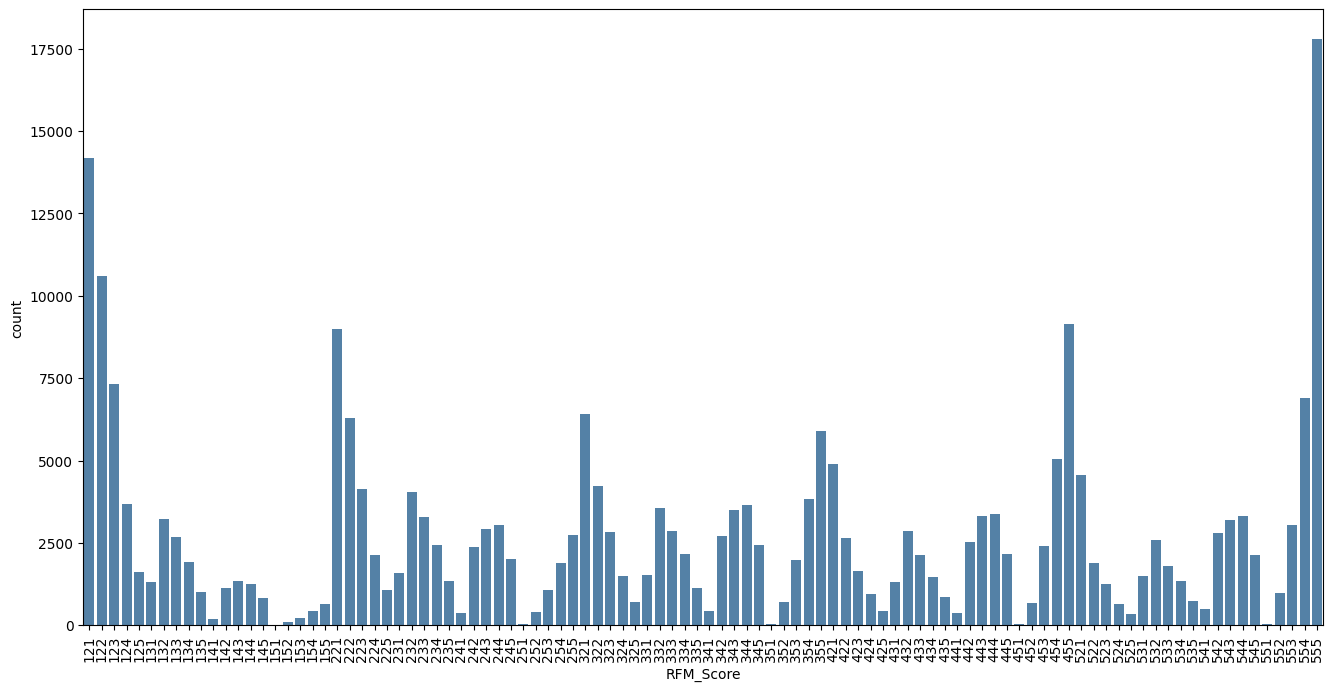

In [ ]:
# Inspect RFM
pd_rfm_sort =pd_rfm.sort_values(["RFM_Score"])

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
plt.xticks(rotation=90)
# sns.histplot(df_rfm_agg_scores["RFMScore"], kde=True, bins=10, ax=ax[0])
sns.countplot(x="RFM_Score", data=pd_rfm_sort,
              color='steelblue')

# sns.histplot(df_rfm_agg_scores["RFMScoreGroup"], color='steelblue', ax=ax[2])

<Axes: xlabel='Montant', ylabel='Count'>

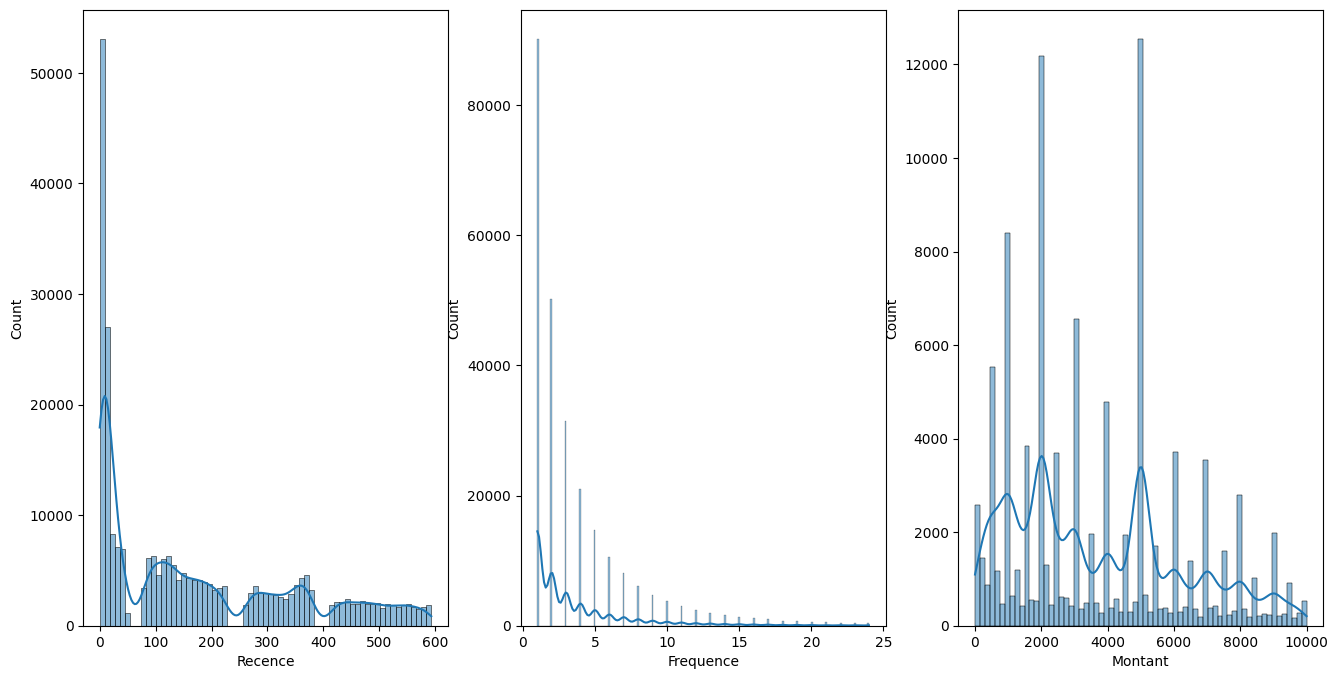

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(pd_rfm['Recence'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(pd_rfm.query('Frequence < 25')['Frequence'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(pd_rfm.query('Montant < 10000')['Montant'], kde=True, ax=ax[2])

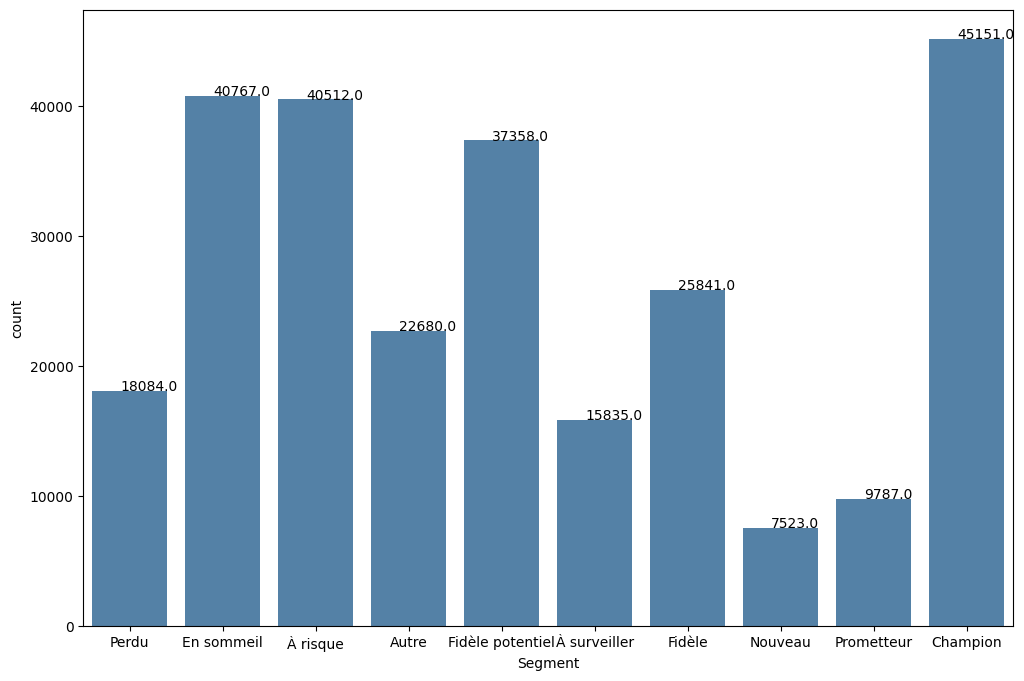

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# sns.histplot(df_rfm_fidelite["Fidelite"], color='steelblue', shrink=.8)
sns.countplot(x="Segment_service", data=pd_rfm_sort, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

<Axes: xlabel='Montant', ylabel='Frequence'>

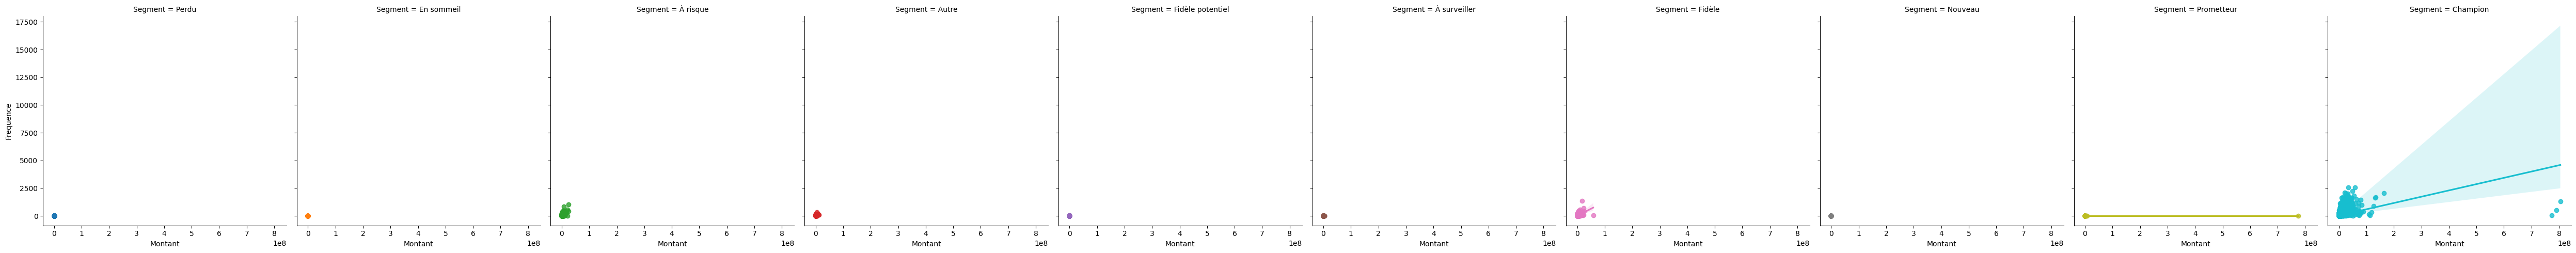

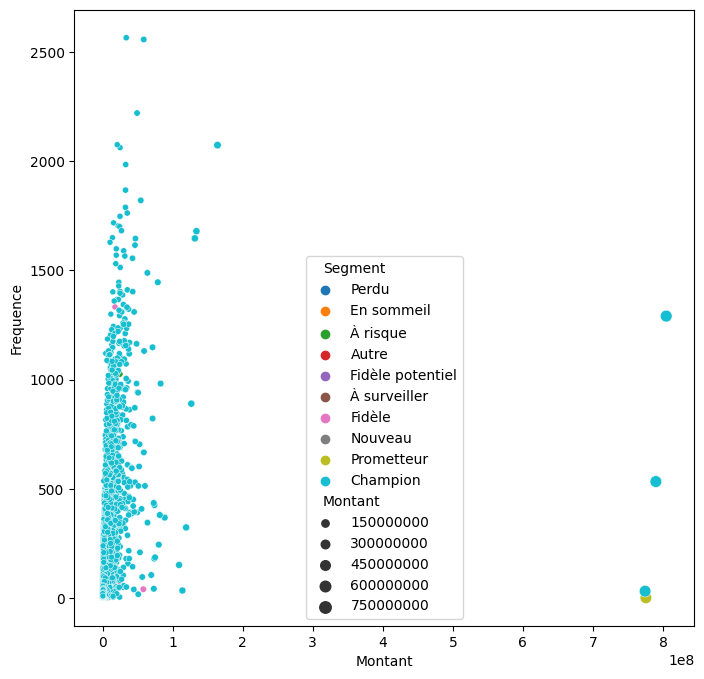

In [ ]:
# Monetary vs Frequency for each segment
sns.lmplot(x='Montant', y='Frequence', data=pd_rfm_sort, col='Segment', hue='Segment', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Montant', y='Frequence', data=pd_rfm_sort, hue='Segment', size='Montant')

<Axes: xlabel='Recence', ylabel='Montant'>

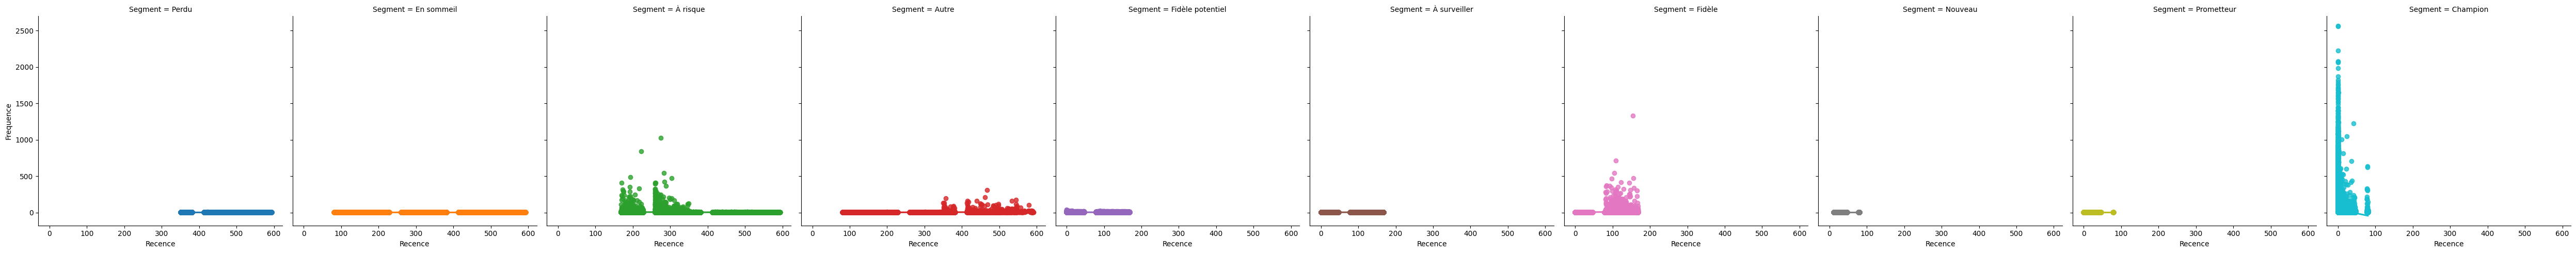

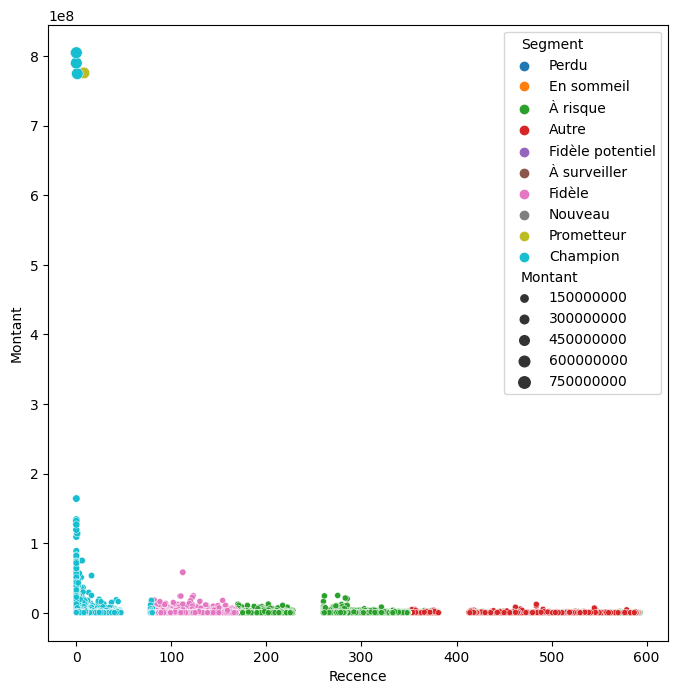

In [ ]:
# Recency vs Frequency for each segment
sns.lmplot(x='Recence', y='Frequence', data=pd_rfm_sort, col='Segment', hue='Segment', fit_reg=True)

# Montant vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recence', y='Montant', data=pd_rfm_sort, hue='Segment', size='Montant')

# **TESTS**

---



In [ ]:
# #Importation des CSV
# path='/content/drive/MyDrive/Colab/Segmentation/#datasets_OM'
# file_list=['2022_2.csv', '2022_3.csv','2022_4.csv','2022_5.csv','2022_6.csv','2022_7.csv',  '2022_8.csv', '2022_8.csv','2022_9.csv','2022_10.csv','2022_11.csv','2022_12.csv','2023_1.csv','2023_2.csv','2023_3.csv','2023_4.csv','2023_5.csv','2023_6.csv','2023_7.csv', ]
# df_agg = spark.read.csv(f'{path}/2022_1.csv', header=True)
# for csv_file in file_list:
#   df = spark.read.csv(f'{path}/{csv_file}', header=True, inferSchema=True)
#   df_agg = df_agg.union(df)

# df_agg.write.csv('#datasets_OM/trusted_om.base_transaction.csv', header=True, mode='overwrite')
# # df_agg.toPandas().to_csv('#datasets_OM/trusted_om.transactions.csv', index=False)
# # Show the RFM DataFrame
# df_agg.show()

In [ ]:
#!git clone https://github.com/asish012/dataanalytics.git